In [28]:
import numpy as np
import pandas as pd
%matplotlib inline

In [53]:
class PipeLine(object):
    """This class deals with the row data and does all feature extraction and
    preprocessing."""
    cols = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    smas = [3, 5, 10]

    def __init__(self, data, header='infer', index_col=None,
                 names=cols, price_df=None, final=None):
        """
        Parameters
        ----------
        data : string containg the csv file containing the price data
        header : int or list of ints, default 'infer'
        names : array-like, default None List of column names to use.
        index_col : int or sequence or False, default None
        price_df : DataFrame in a tidy form conaining datatime index and column names
        final: DataFrame containing the price data and the newly genrated features data
        """
        self.data = data
        self.header = header
        self.names = names
        self.index_col = index_col
        self.price_df = price_df
        self.final = final
        self.y = None

    def read_data(self):
        """Read_data and name the columns."""
        self.price_df = pd.read_csv(self.data, header=self.header,
                                    index_col=self.index_col,
                                    names=self.names)

    def set_datetime_index(self):
        """Creat a date time index and drop the date and time coloumns."""
        dt = self.price_df.date.str.replace('.', '-')\
            + ' ' + \
            self.price_df.time

        self.price_df.set_index(pd.to_datetime(dt), inplace=True)
        self.price_df.drop(['date', 'time'], axis=1, inplace=True)

    def make_features(self, smas=smas, pred_mode=False):
        """Append all features to a dataframe."""
        data = self.price_df.copy()
        data['U_D'] = PipeLine.up_or_down(data)
        data['up_shadow'] = PipeLine.up_shadow(data)
        data['lo_shadow'] = PipeLine.lo_shadow(data)
        data['body'] = PipeLine.body(data)
        data['range'] = PipeLine.candle_range(data)
        data['price'] = PipeLine.median_price(data)
        data['price_change'] = PipeLine.price_change(data)
        data['hour'] = PipeLine.hour_of_the_day(data)
        data['day_of_week'] = PipeLine.day_of_week(data)
        data = pd.concat([data, PipeLine.make_sma(data)[0]], axis=1)
        data = pd.concat([data,PipeLine.sma_change(data)],axis=1)
        
        # drop the sma_n columns for avoiding data leakage.
        data.drop(PipeLine.make_sma(data)[1], axis=1, inplace=True)
        
        
        if not pred_mode:
            data['y'] = data.U_D.shift(-1)
            data.dropna(inplace=True)
            #*********************
            self.y = data.pop('y')
            data.drop(['price','high','low','open','close'],axis=1,inplace=True)
            self.final = data
        else:
            data.dropna(inplace=True)
            data.drop(['price','high','low','open','close'],axis=1,inplace=True)
            self.final = data
        
        
    @staticmethod
    def up_or_down(data):
        """Up or down."""
        return np.where(data['open'] > data['close'], 1, 0)

    @staticmethod
    def up_shadow(data):
        """Return the upper shadow."""
        return -np.where(data['U_D'] == 1, data.high - data.close, data.high - data.open)

    @staticmethod
    def lo_shadow(data):
        """Return the lower shadow."""
        return np.where(data['U_D'] == 1, data.open - data.low, data.close - data.low)

    @staticmethod
    def body(data):
        """Return the body of the candle."""
        return np.where(data['U_D'] == 1, data.close - data.open, data.close - data.open)

    @staticmethod
    def candle_range(data):
        """Return the range of the candle."""
        return data.high - data.low

    @staticmethod
    def median_price(data):
        """Median of [open,close,high,low]."""
        return data[['open', 'close', 'high', 'low']].median(axis=1)

    @staticmethod
    def price_change(data):
        """Return the median price of the currnt candle and the median price of the last candle subtracted from it."""
        previous_candle = data.price.shift(1)
        return data.price - previous_candle

    @staticmethod
    def make_sma(data, SMAs=smas):
        """Take a list of simple moving averages you want to be created."""
        if  not isinstance(SMAs, list):
            print('SMAs has to be of type "list"')

        def_df = pd.DataFrame()

        # create sma for all values in SMAs
        for sma in SMAs:
            def_df['sma_{}'.format(sma)] = data.price.rolling(sma).mean()

        # Return coloumns that starts with sma
        return def_df[[col for col in def_df.columns if 'sma_' in col]], def_df.columns
    
    @staticmethod
    def sma_change(data):
        """Calculate the difference between the currnt value of the SMA and the last one."""
        sma_cols = [col for col in data.columns if 'sma_' in col]
        shifted = data[sma_cols].shift(1)
        sma_change_df = data[sma_cols] - shifted
        # renaming the coloumns 
        sma_change_df.columns = [i+'_change' for i in sma_change_df.columns]
        return sma_change_df
    
    @staticmethod
    
    def hour_of_the_day(data):
        """Return the hour of the day."""
        return data.index.hour
    
    @staticmethod
    def day_of_week(data): 
        """return the day of week."""
        return data.index.dayofweek
        

### usage

In [54]:
d = PipeLine('hist_data/H/AUDUSD.csv')

In [55]:
d.read_data()

In [56]:
d.set_datetime_index()

In [57]:
d.make_features()

In [58]:
data = d.final

In [59]:
data['y'] = d.y

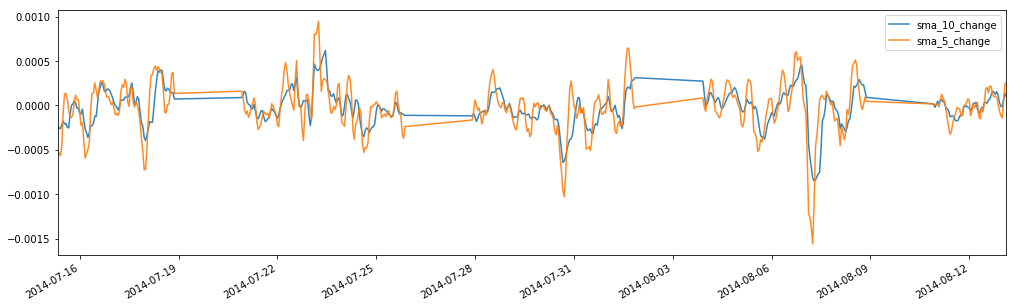

In [60]:
data[['sma_10_change','sma_5_change']].iloc[500:1000].plot(figsize=(17,5), alpha=0.9)

In [61]:
data[['U_D','y']]

,U_D,y
2014-06-16 12:00:00,0,1.0
2014-06-16 13:00:00,1,0.0
2014-06-16 14:00:00,0,0.0
2014-06-16 15:00:00,0,0.0
2014-06-16 16:00:00,0,0.0
2014-06-16 17:00:00,0,1.0
2014-06-16 18:00:00,1,0.0
2014-06-16 19:00:00,0,0.0
2014-06-16 20:00:00,0,1.0
2014-06-16 21:00:00,1,1.0


In [219]:
X = d.final.values

y = d.y.values

In [20]:
data.index.dayofweek
data.index.hour

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', length=18554)

In [27]:
data

,volume,U_D,up_shadow,lo_shadow,body,range,price_change,hour,day_of_week,sma_3_change,sma_5_change,sma_10_change
2014-06-16 12:00:00,1236,0,-0.00041,0.00032,0.00009,0.00064,1.100000e-04,12,0,-0.000097,-0.000522,-7.400000e-05
2014-06-16 13:00:00,1704,1,-0.00038,0.00051,-0.00017,0.00072,1.110223e-16,13,0,-0.000037,-0.000260,-1.080000e-04
2014-06-16 14:00:00,2182,0,-0.00135,0.00198,0.00114,0.00219,4.950000e-04,14,0,0.000202,0.000041,-1.140000e-04
2014-06-16 15:00:00,2675,0,-0.00120,0.00044,0.00031,0.00133,7.350000e-04,15,0,0.000410,0.000224,-9.100000e-05
2014-06-16 16:00:00,1543,0,-0.00042,0.00064,0.00024,0.00082,2.850000e-04,16,0,0.000505,0.000325,-1.100000e-04
2014-06-16 17:00:00,1007,0,-0.00025,0.00071,0.00022,0.00074,2.500000e-04,17,0,0.000423,0.000353,-8.450000e-05
2014-06-16 18:00:00,828,1,-0.00071,0.00074,-0.00063,0.00082,-1.950000e-04,18,0,0.000113,0.000314,2.700000e-05
2014-06-16 19:00:00,1218,0,-0.00052,0.00023,0.00017,0.00058,-2.600000e-04,19,0,-0.000068,0.000163,1.020000e-04
2014-06-16 20:00:00,1012,0,-0.00056,0.00065,0.00044,0.00077,2.950000e-04,20,0,-0.000053,0.000075,1.495000e-04
2014-06-16 21:00:00,1326,1,-0.00019,0.00036,-0.00007,0.00048,2.050000e-04,21,0,0.000080,0.000059,1.920000e-04


In [42]:
d2 = pd.read_csv('hist_data/H/AUDUSD.csv', names=None)

In [43]:
d2.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

In [44]:
d2.set_index('date', inplace=True)

In [46]:
s=  d2.head(10)

In [51]:
s['s'] = s.time.shift(1)
s[['time','s']]

/home/data-sci/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,time,s
date,,
2014.06.16,03:00,NaN
2014.06.16,04:00,03:00
2014.06.16,05:00,04:00
2014.06.16,06:00,05:00
2014.06.16,07:00,06:00
2014.06.16,08:00,07:00
2014.06.16,09:00,08:00
2014.06.16,10:00,09:00
2014.06.16,11:00,10:00
